In [2]:
import os, time, datetime, sys
import numpy as np
import pandas as pd
from collections import Counter
from functools import reduce
from dateutil.relativedelta import relativedelta
from sklearn.metrics import roc_curve, auc, f1_score, mean_squared_error
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib
import random
from IPython.display import display

# 1.1 读取数据并预览

In [3]:
# Read data
userinfo_train = pd.read_csv('./userinfo.csv')
bank_train = pd.read_csv('./bank.csv')
bill_train = pd.read_csv('./bill.csv')
overdue_train = pd.read_csv('./overdue.csv')

df_dict = {"用户信息": userinfo_train,
"银行流水": bank_train,
"账单": bill_train,
"违约记录": overdue_train}

In [4]:
# Show info
for name in df_dict:
    print(name+":", len(df_dict[name]), "行")
    display(df_dict[name].head())

用户信息: 10000 行


,new_user_id,性别,职业,教育程度,婚姻状态,户口类型
0,7259fe272934e0dc348092c37544a445,女,公职,本科及以上,未婚,集体户口
1,0c87f6b1f7e0350a35841ba34df9d26a,男,公职,本科及以上,离异,集体户口
2,74c53a62f15cc039864aefc41170f81b,男,公职,大专,离异,家庭户口
3,211f56f356fa6ecc6334bb73e52c7b16,男,企业,高中,离异,农业户口
4,07b0d9ac7924424894141b2fecfa0ee0,男,公职,本科及以上,已婚,集体户口


银行流水: 1068424 行


,new_user_id,交易时间戳,交易类型,交易金额,工资收入标记,交易时间,交易年,交易月,交易日,交易时,交易分,交易秒
0,65b01fba105ee82613babff7c88929c5,58848407247,1,43.757548,0,2156-06-25 21:58:44,2156,6,25,21,58,44
1,65b01fba105ee82613babff7c88929c5,58849365297,1,42.143743,0,2156-06-27 00:35:29,2156,6,27,0,35,29
2,65b01fba105ee82613babff7c88929c5,58850118237,1,40.189051,0,2156-06-27 21:30:23,2156,6,27,21,30,23
3,65b01fba105ee82613babff7c88929c5,58850118447,1,40.189051,0,2156-06-27 21:30:44,2156,6,27,21,30,44
4,65b01fba105ee82613babff7c88929c5,58850244487,1,40.189051,0,2156-06-28 01:00:48,2156,6,28,1,0,48


账单: 429441 行


,new_user_id,账单时间戳,银行id,上期账单金额,上期还款金额,信用卡额度,本期账单余额,本期账单最低还款额,消费笔数,本期账单金额,...,可用金额,预借现金额度,还款状态,账单时间,账单年,账单月,账单日,账单时,账单分,账单秒
0,eddcaa8984f8db5199ec28323efb18a4,59067443637,6,50.622246,50.657612,52.596975,50.897707,49.846899,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:19:23,2157,3,6,10,19,23
1,eddcaa8984f8db5199ec28323efb18a4,59067444017,6,50.897707,50.901821,52.596975,51.101179,49.911428,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:20:01,2157,3,6,10,20,1
2,eddcaa8984f8db5199ec28323efb18a4,59067444277,6,51.101179,51.137354,52.596975,51.283715,49.977605,1,26.457513,...,26.457513,51.933872,0,2157-03-06 10:20:27,2157,3,6,10,20,27
3,eddcaa8984f8db5199ec28323efb18a4,59067445157,6,51.283715,51.283799,52.915867,52.252502,50.474921,1,26.457513,...,26.457513,52.256811,0,2157-03-06 10:21:55,2157,3,6,10,21,55
4,eddcaa8984f8db5199ec28323efb18a4,59067445627,6,52.252502,52.256812,52.915867,52.304048,50.508400,1,26.457513,...,26.457513,52.256811,0,2157-03-06 10:22:42,2157,3,6,10,22,42


违约记录: 10000 行


,new_user_id,标签,分数
0,eddcaa8984f8db5199ec28323efb18a4,0,80.619639
1,65b01fba105ee82613babff7c88929c5,1,53.052357
2,968083a2d1a7e6b5b85a66b0bc412830,1,46.796518
3,18aeed58fd39a58cc1430a3a417ed7a9,1,82.354501
4,bae4896cea4a34616ae3babca11439ae,1,83.758928


# 1.2 列出空值并删除

In [5]:
# show whether a table contains null value
for name in df_dict:
    print("%s:%s" %(name, np.any(df_dict[name].isnull())))

用户信息:True
银行流水:False
账单:False
违约记录:False


In [6]:
# Show specific info of null value table 
for name in df_dict:
    df = df_dict[name]
    if np.any(df.isnull()):
        print("%s存在空值" %name)
        print(df.isnull().sum(axis=0))
        display(df[df.isnull().any(axis=1)])
        print("存在 %d 行空值" %len(df[df.isnull().any(axis=1)]))

        # Drop null record
        df_dict[name] = df[~df.isnull().any(axis=1)]
        print("%s已更新" %name)

用户信息存在空值
new_user_id    0
性别             0
职业             2
教育程度           0
婚姻状态           1
户口类型           0
dtype: int64


,new_user_id,性别,职业,教育程度,婚姻状态,户口类型
31,3be79a55ccf09062cdff1b9c684179f9,男,NaN,本科及以上,离异,农业户口
135,b074add6f740af33df4230f28d37a333,男,NaN,大专,离异,家庭户口
5345,9f2e0eb314d821f8d075fbc9e64ce4f5,男,公职,高中,NaN,农业户口


存在 3 行空值
用户信息已更新


# 1.3 编码
分类编码和独热编码

In [7]:
# Generate dictionary of code for a certain table.
def genCode(pdtable, colList):
    # For safety, you must commit a list sured by yourself.

    code_dict = {}

    for col in colList:
        # Show unique value of a column
        colValue = list(pdtable[col].unique())
        print(col, colValue)

        # Enode of column
        dict = {}
        for index in range(len(colValue)):
            dict[colValue[index]] = index

        # Show result
        print("编码：%s\n" %dict)
        
        # Store data
        code_dict[col] = dict
    return code_dict

col_list=list(df_dict['用户信息'])
col_list.remove('new_user_id')
code_dict = genCode(df_dict['用户信息'], col_list)

df_dict['用户信息'] = df_dict['用户信息'].replace(code_dict)


性别 ['女', '男', '未知']
编码：{'女': 0, '男': 1, '未知': 2}

职业 ['公职', '企业', '事业单位', '无业', '学生']
编码：{'公职': 0, '企业': 1, '事业单位': 2, '无业': 3, '学生': 4}

教育程度 ['本科及以上', '大专', '高中', '初中及以下', '未知']
编码：{'本科及以上': 0, '大专': 1, '高中': 2, '初中及以下': 3, '未知': 4}

婚姻状态 ['未婚', '离异', '已婚', '丧偶', '其他情况', '未知']
编码：{'未婚': 0, '离异': 1, '已婚': 2, '丧偶': 3, '其他情况': 4, '未知': 5}

户口类型 ['集体户口', '家庭户口', '农业户口', '其他户口', '未知']
编码：{'集体户口': 0, '家庭户口': 1, '农业户口': 2, '其他户口': 3, '未知': 4}



In [7]:
# One-Hot Encoding
col_list=list(df_dict['用户信息'])
col_list.remove('new_user_id')
df_dict['用户信息'] = pd.get_dummies(df_dict['用户信息'], columns=col_list)
df_dict['用户信息'].head(5)

,new_user_id,性别_0,性别_1,性别_2,职业_0,职业_1,职业_2,职业_3,职业_4,教育程度_0,...,婚姻状态_1,婚姻状态_2,婚姻状态_3,婚姻状态_4,婚姻状态_5,户口类型_0,户口类型_1,户口类型_2,户口类型_3,户口类型_4
0,7259fe272934e0dc348092c37544a445,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
1,0c87f6b1f7e0350a35841ba34df9d26a,0,1,0,1,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,0
2,74c53a62f15cc039864aefc41170f81b,0,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
3,211f56f356fa6ecc6334bb73e52c7b16,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,1,0,0
4,07b0d9ac7924424894141b2fecfa0ee0,0,1,0,1,0,0,0,0,1,...,0,1,0,0,0,1,0,0,0,0


# 2.1 尝试单变量
职业、教育程度、婚姻状态或户口类型

In [9]:
# min-max标准化

def mNormalization(dataframe, column):
    single = pd.DataFrame(dataframe[column],columns=[column])
    single = single.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    dataframe[column] = single[column]
    return dataframe

df = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id', how='left')
df = mNormalization(df, '分数')
# df['分数'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

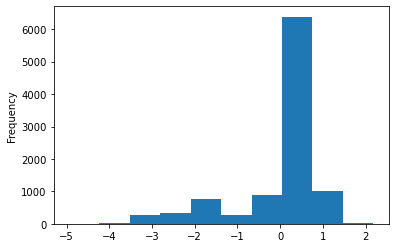

In [87]:
# Z-score标准化

def zNormalization(dataframe, column):
    single = pd.DataFrame(dataframe[column],columns=[column])
    single = single.apply(lambda x: (x - np.mean(x)) / np.std(x))
    dataframe[column] = single[column]
    return dataframe

df = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id', how='left')
df = zNormalization(df, '分数')
# df['分数'].plot.hist()

In [8]:
# Continue without normalization
df = pd.merge(df_dict['用户信息'], df_dict['违约记录'], on='new_user_id', how='left')
df.head()

,new_user_id,性别,职业,教育程度,婚姻状态,户口类型,标签,分数
0,7259fe272934e0dc348092c37544a445,0,0,0,0,0,0,70.260853
1,0c87f6b1f7e0350a35841ba34df9d26a,1,0,0,1,0,1,22.963381
2,74c53a62f15cc039864aefc41170f81b,1,0,1,1,1,1,33.866533
3,211f56f356fa6ecc6334bb73e52c7b16,1,1,2,1,2,0,80.170224
4,07b0d9ac7924424894141b2fecfa0ee0,1,0,0,2,0,0,73.980588


In [18]:
def SingleVarReg(dataframe, depVar, indVar, testsize=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(dataframe[[indVar]], dataframe[[depVar]], test_size=testsize)
    model = LinearRegression()
    model.fit(X_train, Y_train)
    Y_predict_value = model.predict(X_test)
    
    mse = mean_squared_error(Y_test, Y_predict_value)
    print("回归任务：%s\n单变量：%s\n均方差：%.4f\n" %(depVar, indVar, mse))

features = ['职业','教育程度','婚姻状态','户口类型']
# df = mNormalization(df, '职业')
for feature in features:
    SingleVarReg(df, '分数', feature)

回归任务：分数
单变量：职业
均方差：189.7116

回归任务：分数
单变量：教育程度
均方差：206.1938

回归任务：分数
单变量：婚姻状态
均方差：209.2715

回归任务：分数
单变量：户口类型
均方差：181.1383



C:\Users\bryan\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


职业


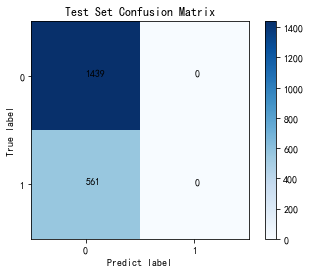

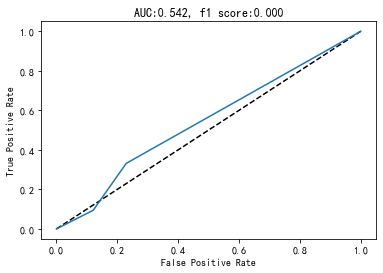

C:\Users\bryan\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


教育程度


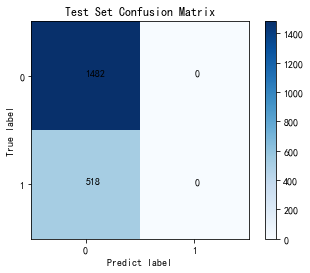

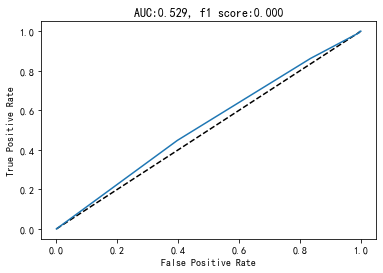

C:\Users\bryan\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


婚姻状态


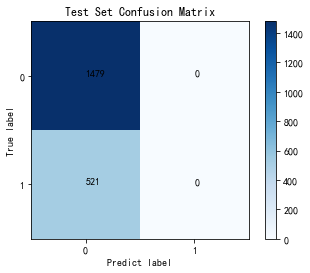

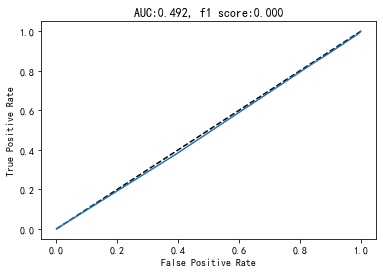

C:\Users\bryan\AppData\Roaming\Python\Python38\site-packages\sklearn\utils\validation.py:985: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


户口类型


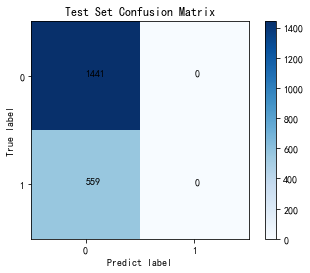

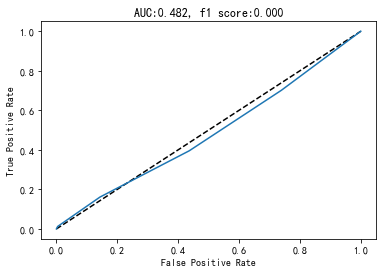

In [26]:
from sklearn.metrics import confusion_matrix

def SingleVarClf(dataframe, depVar, indVar, testsize=0.2):
    X_train, X_test, Y_train, Y_test = train_test_split(df[[indVar]], df[[depVar]], test_size=testsize)
    model = LogisticRegression()
    model.fit(X_train, Y_train)
    Y_predict_value = model.predict_proba(X_test)[:, 1]  # 各个测试样本 softmax ，用于计算 roc
    Y_predict_label = model.predict(X_test)  # 各个测试样本预测出的标签

    # Plot confusion matrix
    confusion = confusion_matrix(Y_test, Y_predict_label)
    # print(confusion)

    print(indVar)
    # Generate ticks
    classes = list(set(df[depVar]))
    classes.sort()
    # matplotlib.rcParams['font.sans-serif'] = ['KaiTi']
    plt.title('Test Set Confusion Matrix')
    plt.imshow(confusion, cmap=plt.cm.Blues)
    plt.colorbar()
    plt.xticks(range(len(confusion)), classes)
    plt.yticks(range(len(confusion)), classes)
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    for y_index in range(len(confusion)):
        for x_index in range(len(confusion[y_index])):
            plt.text(x_index, y_index, confusion[y_index][x_index])
    plt.show()

    # Plot ROC curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_predict_value)
    roc_auc = auc(fpr, tpr)
    plt.title('AUC:%.3f, f1 score:%.3f' %(roc_auc, f1_score(Y_test, Y_predict_label)))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.show()

features = ['职业','教育程度','婚姻状态','户口类型']
for feature in features:
    SingleVarClf(df, '标签', feature)